#Medical imaging project - CAMELYON16 Challenge
Instructor: Prof. Joshua Gordon

Team members: Jiayu Li (jl5497), Zhicheng Song (zs2441)

##Project Overview

The most common method to detect breast cancer metastases is by conducting visual inspection of whole-slide images of lymph node sections. However, this method requires large amounts of reading times for pathologists in order to get a precise diagnosis, since the tumors are usually small compared with the whole slide. Also, because one single slide contains about 100 billion pixels and takes up a storage space of around 2GB, due to the information of multiple magnification scales it includes, CNN architectures cannot be directly applied here to make a prediction.

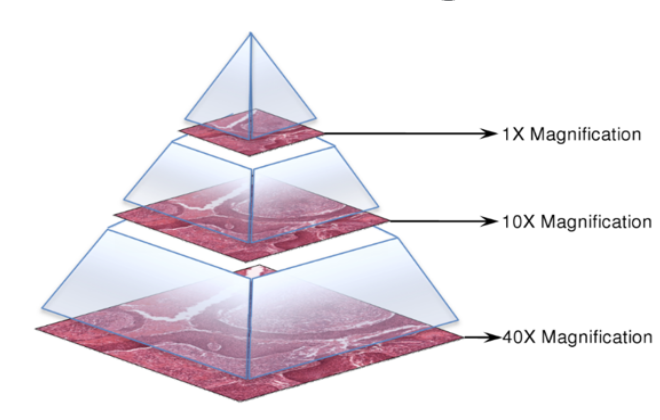

Our goal in this project is to develop a tool with the 110 officially provided slide images and masks that marked the locations of the tumors, as a substitution or an assistance of pathology experts, with equal or even higher diagnosis accracy. Deep neural networks are applied in the project for the tumors detection task, consider the rapid development of relevant fields in recent years. 

To solve the problem of giant slides, we randomly sliced 120 small parts of 256×256 from the each of the initial slides and their corresponding tumor masks as a representation of the whole slide. We found that most of the partial images contains no cell tissues (only shows the background). We thus created a image filter based on Otsu Method to rule out the non-tissue images, that is to say, we traversed the gray levels from 0 to 255, and select the one with the maximal between-class variance, the variance between the foreground (cell tissues) and background as the threshold. And for each partial image, we calculated the portion of foreground will the threshold and decided whether to keep the image or not based on the foreground portion of the whole slide. We conducted the slicing and process in the corresponding location of a single slide in level 3, 4 and 5 (×20, ×10, ×5 magnification) over and over again if the slicing part is not ruled out in level 7 (initial size).

Then we found that there were a lot more images without tumors than those with tumors in our dataset after checking the sliced tumor masks. In order to deal with the data imbalance issue, we implemented data augmentation with flipping, rotating, and adjusing contrast ratio, saturation, brightness, gamma correction and hue. 

For the model training part, U-Net is generally applied as our architecture. It is a fully convolutional neural network developed specifically for biomedical image segmentation, which is appropriate for our project. We loaded our data in, divided them into training and validation sets, zipped them into trainable format for the model, and create pipelines with autotune to accelerate the reading process. The tumor locating accuracy can be as high as 0.92 among the models for layer 3, 4, 5 respectively.

After saving the models, we sliced each whole slide image into parts and inserted them into our pre-trained U-Net model, predicting the possible tumor mask location and shape, and combine them together to form a whole predicted slide image. After comparing with the true tumor masks, we obtained a satisfying result, as shown in Part III in another notebook.

##Reference
- [CAMELYON16](https://camelyon16.grand-challenge.org/)
- [OpenSlide](https://openslide.org/)
- [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom)
- [Detecting Cancer Metastases on Gigapixel Pathology Images
](https://arxiv.org/abs/1703.02442)
- [Otsu Method](https://ieeexplore.ieee.org/document/4310076)
- [U-Net: Convolutional Networks for Biomedical Image Segmentation
](https://arxiv.org/abs/1505.04597)


#Part I. Data pre-processing

In [ ]:
import importlib, warnings
exist_openslide = importlib.util.find_spec('openslide')
if not exist_openslide:
    !apt-get install openslide-tools
    !pip install openslide-python
else:
    warnings.warn('Openslide already installed.')

In [ ]:
from openslide import open_slide
from matplotlib import pyplot as plt
import numpy as np
import os
from google.colab import drive
from skimage.color import rgb2gray
np.random.seed(0)
import tensorflow as tf
from PIL import Image as Img
import progressbar

In [ ]:
drive.mount('/content/drive', force_remount=True)
ROOT = '/content/drive/My Drive/applied_deep_learning/project/'

Mounted at /content/drive


In [ ]:
NUM_LEVELS = 8
LAST_LEVEL = 7
NUM_TUMORS = 110
IMG_SIZE = 256
GRAY_SCALE_NUMS = 255
DOWN_FACTOR_LAST = 128
NUM_REGIONS_PER_SLIDE = 120
AUGMENTATIONS_LOC = [lambda image: tf.image.flip_left_right(image),
                     lambda image: tf.image.flip_up_down(image),
                     lambda image: tf.image.rot90(image)]

AUGMENTATIONS_LGT = [lambda image: tf.image.adjust_hue(image, delta=0.04),
                     lambda image: tf.image.adjust_contrast(image, contrast_factor=0.75),
                     lambda image: tf.image.adjust_saturation(image, saturation_factor=0.25),
                     lambda image: tf.image.adjust_brightness(image, delta=0.1),
                     lambda image: tf.image.adjust_gamma(image, gamma=0.2)]
LABEL_MARKS = {'tumor': 1, 'non-tumor': 0}

**1. Prepare the data**

In [ ]:
class PreProcessing(object):
    def __init__(self):
        self.slides = []
        self.tumor_masks = []
        self.import_all_tifs()

        self.last_level = []
        self.read_last_level()

        self.gray_thresholds = []
        self.total_pixels_percentiles = []
        self.get_all_thresholds_and_percentiles()

        self.all_tumor_rate = 0
        self.aug_times = 0
        self.labels = [[],[],[]]

In [ ]:
class PreProcessing(PreProcessing):
    def import_all_tifs(self):
        """
        Import all slides and corresponding tumor masks
        Append to two lists respectively
        """
        bar = progressbar.ProgressBar()
        for i in bar(range(NUM_TUMORS)):
            slide_path = ROOT + 'slides/tumor_{}.tif'.format(str(i + 1).zfill(3))
            tumor_mask_path = ROOT + 'slides/tumor_{}_mask.tif'.format(str(i + 1).zfill(3))
            if os.path.exists(slide_path) and os.path.exists(tumor_mask_path): 
                slide = open_slide(slide_path)
                tumor_mask = open_slide(tumor_mask_path)
                self.slides.append(slide)
                self.tumor_masks.append(tumor_mask)
        print('All slides and tumor masks successfully imported.')

In [ ]:
class PreProcessing(PreProcessing):    
    def read_single_slide(self, slide, x, y, level, width, height, as_float=False):
        """
        Read a region from a single slide
        Return a numpy RBG array
        Input:
            slide_path (str): the path of the whole slide
            x (int): x position at level 0
            y (int): y position at level 0
            level (int): zoom level of the region
            width (int): width of the image at level=level 
            height (int): height of the image at level=level 
        """
        im = slide.read_region((x,y), level, (width, height))
        im = im.convert('RGB') # drop the alpha channel
        if as_float:
            im = np.asarray(im, dtype=np.float32)
        else:
            im = np.asarray(im)
        assert im.shape == (height, width, 3)
        return im

**2. Slice the data**

In [ ]:
class PreProcessing(PreProcessing):    
    def read_last_level(self):
        """
        Read the last level of each slides specifically for further calculation
        of gray scale thresholds and tissue portions
        Append to a list
        """
        bar = progressbar.ProgressBar()
        for i in bar(range(len(self.slides))):
            slide_image = self.read_single_slide(self.slides[i], x=0, y=0, level=LAST_LEVEL, 
                                                 width=self.slides[i].level_dimensions[LAST_LEVEL][0],
                                                 height=self.slides[i].level_dimensions[LAST_LEVEL][1])
            self.last_level.append(slide_image)
        print('All slides in the last level successfully read in.')

In [ ]:
class PreProcessing(PreProcessing):    
    def get_gray_threshold_otsu(self, gray_image):
        """
        Calculate the gray scale threshold of the image based on Otsu's Method,
        that is, maximize the between-class variance of foreground (cell tissues)
        and background.
        Return a float
        Input:
            gray_image (ndarray): slide image already converted to gray-scale map
        """
        height, width = gray_image.shape
        best_threshold = max_var_inter = 0
        for scale in range(GRAY_SCALE_NUMS + 1):
            curr_threshold = scale / GRAY_SCALE_NUMS
            front = gray_image[np.where(gray_image <= curr_threshold)]
            back = gray_image[np.where(gray_image > curr_threshold)]
            mean_front = np.mean(front) if len(front) > 0 else 0
            mean_back = np.mean(back) if len(back) > 0 else 0
            percentile_front, percentile_back = len(front) / (height * width), len(back) / (height * width)

            var_inter = percentile_front * percentile_back * pow(mean_front - mean_back, 2)
            if var_inter > max_var_inter:
                max_var_inter = var_inter
                best_threshold = curr_threshold
        return best_threshold

In [ ]:
class PreProcessing(PreProcessing):        
    def get_pixels_percentile(self, gray_image, threshold):
        """
        Calculate the cell tissue portion of the image with the given gray
        scale threshold, that is, the percentile of foreground pixels 
        (gray scale <= threshold) in the image
        Return a float
        Input:
            gray_image (ndarray): slide image already converted to gray-scale map
            threshold (float): gray scale threshold calculated with Otsu's Method
        """
        indices = np.where(gray_image <= threshold)
        tissue_pixels = list(zip(indices[0], indices[1]))
        pixels_percentile = len(tissue_pixels) / float(gray_image.shape[0] * gray_image.shape[0])
        return pixels_percentile

In [ ]:
class PreProcessing(PreProcessing):         
    def get_all_thresholds_and_percentiles(self):
        """
        Calculate the gray scale thresholds and tissue portions in the last level
        of the slides as a image filter for later sliced images
        Append to two lists respectively
        """
        bar = progressbar.ProgressBar()
        for i in bar(range(len(self.last_level))):
            gray_image = rgb2gray(self.last_level[i])
            assert gray_image.shape == (self.last_level[i].shape[0], self.last_level[i].shape[1])
            threshold = self.get_gray_threshold_otsu(gray_image)
            self.gray_thresholds.append(threshold)
            self.total_pixels_percentiles.append(self.get_pixels_percentile(gray_image, threshold))      
        print('Gray thresholds and total pixels percentile for all slides successfully calculated.')

In [ ]:
class PreProcessing(PreProcessing):         
    def select_single_partial_image(self, index, levels):
        """
        Continuously select a random sliced(partial) image from the given levels 
        of slide and the corresponding tumor mask with index in the slides list 
        until it is not ruled out by the filter.
        Return a list with 3 sliced slides and 3 sliced masks
        Input:
            index (int): index of the slide and mask to be sliced(partial)
            levels (List[int]): magnification levels of the slide to get
        """
        level_1, level_2, level_3 = levels
        width, height = self.slides[index].level_dimensions[LAST_LEVEL]
        down_factor_1, down_factor_2, down_factor_3 = pow(2, level_1), pow(2, level_2), pow(2, level_3)
        pixels_percentile = 0
        while pixels_percentile < self.total_pixels_percentiles[LAST_LEVEL]:
            x_position = np.random.randint(IMG_SIZE//2, width-IMG_SIZE//2) * DOWN_FACTOR_LAST
            y_position = np.random.randint(IMG_SIZE//2, height-IMG_SIZE//2) * DOWN_FACTOR_LAST
            selected_slide_region_last = self.read_single_slide(self.slides[index], 
                                                                x=x_position-IMG_SIZE//2, 
                                                                y=y_position-IMG_SIZE//2,
                                                                level=LAST_LEVEL, width=IMG_SIZE//4, height=IMG_SIZE//4)
            gray_region_last = rgb2gray(selected_slide_region_last)
            pixels_percentile = self.get_pixels_percentile(gray_region_last, self.gray_thresholds[index])
        
        selected_slide_region_1 = self.read_single_slide(self.slides[index], 
                                                         x=x_position-IMG_SIZE//2 * down_factor_1, 
                                                         y=y_position-IMG_SIZE//2 * down_factor_1,
                                                         level=level_1, width=IMG_SIZE, height=IMG_SIZE)
        selected_slide_region_2 = self.read_single_slide(self.slides[index], 
                                                         x=x_position-IMG_SIZE//2 * down_factor_2, 
                                                         y=y_position-IMG_SIZE//2 * down_factor_2,
                                                         level=level_2, width=IMG_SIZE, height=IMG_SIZE)
        selected_slide_region_3 = self.read_single_slide(self.slides[index], 
                                                         x=x_position-IMG_SIZE//2 * down_factor_3, 
                                                         y=y_position-IMG_SIZE//2 * down_factor_3,
                                                         level=level_3, width=IMG_SIZE, height=IMG_SIZE)

        selected_tumor_mask_region_1 = self.read_single_slide(self.tumor_masks[index], 
                                                              x=x_position-IMG_SIZE//2 * down_factor_1, 
                                                              y=y_position-IMG_SIZE//2 * down_factor_1,
                                                              level=level_1, width=IMG_SIZE, height=IMG_SIZE)
        selected_tumor_mask_region_2 = self.read_single_slide(self.tumor_masks[index], 
                                                              x=x_position-IMG_SIZE//2 * down_factor_2, 
                                                              y=y_position-IMG_SIZE//2 * down_factor_2,
                                                              level=level_2, width=IMG_SIZE, height=IMG_SIZE)
        selected_tumor_mask_region_3 = self.read_single_slide(self.tumor_masks[index], 
                                                              x=x_position-IMG_SIZE//2 * down_factor_3, 
                                                              y=y_position-IMG_SIZE//2 * down_factor_3,
                                                              level=level_3, width=IMG_SIZE, height=IMG_SIZE)                                                      
        return [[selected_slide_region_1, selected_slide_region_2, selected_slide_region_3], 
               [selected_tumor_mask_region_1, selected_tumor_mask_region_2, selected_tumor_mask_region_3]]

In [ ]:
class PreProcessing(PreProcessing):         
    def partial_all_images(self, levels):
        """
        Partial all the slides in the slides list, with each generating 100 images
        Save the sliced slides and masks. Also define the label of each sliced
        slide by its corresponding mask to .JPEG files. Also calculated the rate 
        between the 2 kinds of data (tumor and non-tumor) in order to decide the
        augmentation size
        Input:
            levels (List[int]): magnification levels of the slide to get
        """
        count = 0
        bar = progressbar.ProgressBar()
        for index in bar(range(len(self.slides))):
            for i in range(NUM_REGIONS_PER_SLIDE):
                slide_regions, tumor_mask_regions = self.select_single_partial_image(index, levels)
                for j in range(len(levels)):
                    slide_region_file = '{}partials/level_{}/slides/{}_{}'.format(ROOT, str(levels[j]), str(index), str(i))
                    img_slide = Img.fromarray(slide_regions[j], 'RGB')
                    img_slide.save(slide_region_file, 'JPEG')
                    tumor_mask_region_file = '{}partials/level_{}/tumor_masks/{}_{}'.format(ROOT, str(levels[j]), str(index), str(i))
                    img_mask = Img.fromarray(tumor_mask_regions[j].astype('uint8'))
                    img_mask.save(tumor_mask_region_file, 'JPEG')

                if np.sum(tumor_mask_regions[0]) > 0:
                    self.labels[0].append(LABEL_MARKS['tumor'])
                    self.labels[1].append(LABEL_MARKS['tumor'])
                    self.labels[2].append(LABEL_MARKS['tumor'])
                    count += 1

                elif np.sum(tumor_mask_regions[1]) > 0:
                    self.labels[0].append(LABEL_MARKS['non-tumor'])
                    self.labels[1].append(LABEL_MARKS['tumor'])
                    self.labels[2].append(LABEL_MARKS['tumor'])
                    
                elif np.sum(tumor_mask_regions[2]) > 0:
                    self.labels[0].append(LABEL_MARKS['non-tumor'])
                    self.labels[1].append(LABEL_MARKS['non-tumor'])
                    self.labels[2].append(LABEL_MARKS['tumor'])

                else:
                    self.labels[0].append(LABEL_MARKS['non-tumor'])
                    self.labels[1].append(LABEL_MARKS['non-tumor'])
                    self.labels[2].append(LABEL_MARKS['non-tumor'])

        self.all_tumor_rate = count / len(self.labels[0])
        self.aug_times = int((1 - self.all_tumor_rate) / self.all_tumor_rate) - 1
        print('All slides and tumor masks successfully partialed and saved.')

In [ ]:
class PreProcessing(PreProcessing):         
    def save_labels(self):
        """
        Save all the labels lists to .npy files
        """
        self.labels = np.array(self.labels)
        for i in range(len(self.labels)):
             labels_file = '{}partials/level_{}/labels'.format(ROOT, str(i + 3))
             np.save(labels_file, self.labels[i])

**3. Conduct data augmentation**

In [ ]:
class PreProcessing(PreProcessing):         
    def single_data_augmentation(self, slides, tumor_masks, start_part_index):
        """
        Conduct data augmentation for a slide part and its corresponding tumor
        mask in 3 levels. For slide parts both its location and vision features
        are modified by randomly select several augmentation operations from the
        global functions list. For masks only the location features are modified,
        with the same operations as above. Only those with tumors in all 3 levels
        can be augmented.
        Save the augmented images to .JPEG file
        Input:
            slides (List[ndarray]): the slide part in 3 levels to be augmented
            tumor_masks (List[ndarray]): the corresponding mask part in 3 levels to be augmented
            start_part_index (int): relevant to the name of the output .JPEG file
        """
        for index in range(self.aug_times):
            choice_loc = np.random.randint(len(AUGMENTATIONS_LOC))
            choices_lgt = np.random.randint(low=0, high=len(AUGMENTATIONS_LGT), size=2)
            for i, (slide, tumor_mask) in enumerate(zip(slides, tumor_masks)):
                slide = AUGMENTATIONS_LOC[choice_loc](slide)
                tumor_mask = AUGMENTATIONS_LOC[choice_loc](tumor_mask) 
                for choice in choices_lgt:
                    slide = AUGMENTATIONS_LGT[choice](slide)
                slide, tumor_mask = slide.numpy(), tumor_mask.numpy()
                slide_aug_file = '{}partials/level_{}/slides/{}_{}'.format(ROOT, str(i + 3),
                                                                           str(len(self.slides)),
                                                                           str(start_part_index + index))
                img_slide = Img.fromarray(slide, 'RGB')                    
                img_slide.save(slide_aug_file, 'JPEG')
                tumor_mask_aug_file = '{}partials/level_{}/tumor_masks/{}_{}'.format(ROOT, str(i + 3), 
                                                                                     str(len(self.slides)), 
                                                                                     str(start_part_index + index))
                img_mask = Img.fromarray((tumor_mask).astype('uint8'))
                img_mask.save(tumor_mask_aug_file, 'JPEG')
                self.labels[i].append(LABEL_MARKS['tumor'])

In [ ]:
class PreProcessing(PreProcessing):         
    def data_augmentation(self):
        """
        Conduct data augmentation for all the slide parts and their corresponding
        tumor masks
        Save all the augmented images and new labels
        """
        count = 0
        bar = progressbar.ProgressBar()
        for i in bar(range(len(self.labels[0]))):
            if self.labels[0][i] == 1:
                slide_index, part_index = divmod(i, NUM_REGIONS_PER_SLIDE)
                slides, tumor_masks = [], []
                for j in range(len(self.labels)):
                    slide_file = '{}partials/level_{}/slides/{}_{}'.format(ROOT, str(j + 3), str(slide_index), str(part_index))
                    tumor_mask_file = '{}partials/level_{}/tumor_masks/{}_{}'.format(ROOT, str(j + 3), str(slide_index), str(part_index))
                    slide = plt.imread(slide_file)
                    tumor_mask = plt.imread(tumor_mask_file)
                    slides.append(slide)
                    tumor_masks.append(tumor_mask)
                self.single_data_augmentation(slides, tumor_masks, count * self.aug_times)
                count += 1
        self.save_labels()
        print('All data successfully augmented.')

In [ ]:
class PreProcessing(PreProcessing):         
    def convert_tumor_mask(self):
        """
        Read in all the tumor mask parts from the path and convert them from 3D
        images to 2D images
        Save them back and cover the original file
        """
        bar = progressbar.ProgressBar()
        for i in bar(range(len(self.labels))):
            tumor_masks_path = '{}partials/level_{}/tumor_masks'.format(ROOT, i + 3)
            tumor_masks_dir = os.listdir(tumor_masks_path)
            tumor_masks_dir.sort(key=lambda x: int(x.split('.')[0]))
            for path in tumor_masks_dir:
                tumor_mask =  plt.imread(os.path.join(tumor_masks_path, path))
                tumor_mask = tumor_mask[:,:,0]
                img = Img.fromarray((tumor_mask).astype('uint8'), mode='L')                
                img.save(os.path.join(tumor_masks_path, path), "JPEG")
        print('All masks successfully converted.')

**4. Run the whole preprocessing process**

Now all the relevant member functions in the preprocessing class have been defined and we are able to run the whole data preprocessing process as below.

In [ ]:
process = PreProcessing()

100% (110 of 110) |######################| Elapsed Time: 0:02:03 Time:  0:02:03
  4% (1 of 21) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:03

All slides and tumor masks successfully imported.


100% (21 of 21) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
N/A% (0 of 21) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

All slides in the last level successfully read in.


100% (21 of 21) |########################| Elapsed Time: 0:01:59 Time:  0:01:59


Gray thresholds and total pixels percentile for all slides successfully calculated.


In [ ]:
process.partial_all_images([3,4,5])

100% (21 of 21) |########################| Elapsed Time: 0:06:49 Time:  0:06:49


All slides and tumor masks successfully partialed and saved.


After we finished the partial process, we find that the number of tumor data are pretty small compared with the non-tumor data for all the 3 levels, as shown below. Therefore data augmentation is required to reduce the imbalance.

In [ ]:
for level in range(3):
    print('Total number of slide images: {}, with the number of tumors versus the one of non-tumors in level {}: {} vs {}'.format(len(process.labels[level]),
                                                                                                                                  level + 3,
                                                                                                                                  sum(process.labels[level]),
                                                                                                                                  len(process.labels[level]) - sum(process.labels[level])))

Total number of slide images: 2520, with the number of tumors versus the one of non-tumors in level 3: 204 vs 2316
Total number of slide images: 2520, with the number of tumors versus the one of non-tumors in level 4: 291 vs 2229
Total number of slide images: 2520, with the number of tumors versus the one of non-tumors in level 5: 474 vs 2046


In [ ]:
process.data_augmentation()

100% (2520 of 2520) |####################| Elapsed Time: 0:02:46 Time:  0:02:46


All data successfully augmented.


After we conducted data augmentation for all the slide slices and tumor masks, we are able to observe a nearly equal number of data in two classes in all the 3 levels, as shown below.

In [ ]:
for level in range(3):
    print('Total number of slide images: {}, with the number of tumors versus the one of non-tumors in level {}: {} vs {}'.format(len(process.labels[level]),
                                                                                                                                  level + 3,
                                                                                                                                  sum(process.labels[level]),
                                                                                                                                  len(process.labels[level]) - sum(process.labels[level])))

Total number of slide images: 4560, with the number of tumors versus the one of non-tumors in level 3: 2244 vs 2316
Total number of slide images: 4560, with the number of tumors versus the one of non-tumors in level 4: 2331 vs 2229
Total number of slide images: 4560, with the number of tumors versus the one of non-tumors in level 5: 2514 vs 2046


In [ ]:
process.convert_tumor_mask()

100% (3 of 3) |##########################| Elapsed Time: 0:02:03 Time:  0:02:03


All masks successfully converted.


**5. Test the validity of our functions**

To test the validity of our calculation member functions, we manually select a slide from the dataset and calculate its gray scale threshold and cell tissue portion. As calculated below, the gray scale threshold is 180, and around 41% of its pixels are cell tissues.

(-0.5, 735.5, 559.5, -0.5)

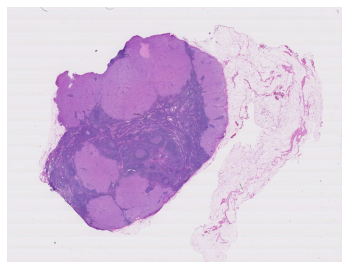

In [ ]:
test_slide = process.last_level[-1]
figure = plt.figure(figsize=(6,6))
plt.imshow(test_slide)
plt.axis('off')

In [ ]:
threshold = process.get_gray_threshold_otsu(gray_image=rgb2gray(test_slide))
print('Gray scale threshold for the test slide: ', int(threshold * GRAY_SCALE_NUMS))

Gray scale threshold for the test slide:  180


In [ ]:
portion = process.get_pixels_percentile(gray_image=rgb2gray(test_slide), threshold=threshold)
print('Cell tissue portion for the test slide: {}%'.format(round(portion * 100)))

Cell tissue portion for the test slide: 41%


To test the validity of our data augmentation functions, we manually select a partial slide and its corresponding mask from our data path and find their augmented images, as shown below. We are able to observe from the plots that our augmentation functions works pretty good.

(-0.5, 255.5, 255.5, -0.5)

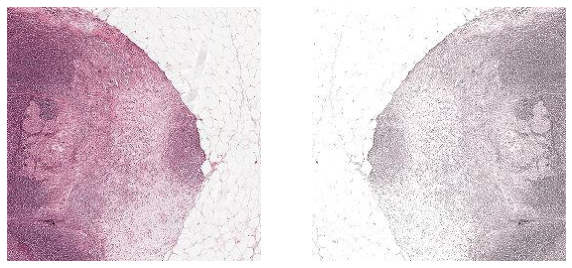

In [ ]:
test_slice_file = '{}partials/level_5/slides/0_4'.format(ROOT)
test_slice = plt.imread(test_slice_file)
test_slice_aug_file = '{}partials/level_5/slides/21_5'.format(ROOT)
test_slice_aug = plt.imread(test_slice_aug_file)

figure = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(test_slice)
plt.axis('off')
plt.subplot(122)
plt.imshow(test_slice_aug)
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

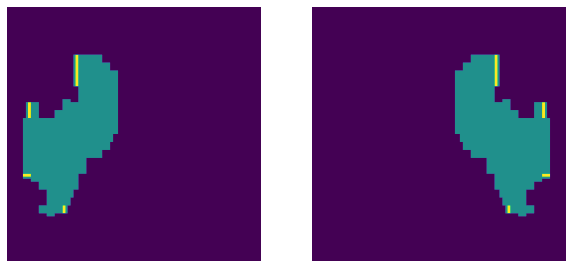

In [ ]:
test_mask_file = '{}partials/level_5/tumor_masks/0_4'.format(ROOT)
test_mask = plt.imread(test_mask_file)
test_mask_aug_file = '{}partials/level_5/tumor_masks/21_5'.format(ROOT)
test_mask_aug = plt.imread(test_mask_aug_file)

figure = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(test_mask)
plt.axis('off')
plt.subplot(122)
plt.imshow(test_mask_aug)
plt.axis('off')